# Intuit Quickbooks Upgrade

* Team-lead GitHub userid: rsm-xic060
* Group name: group_20
* Team member names:
    - Ran Ji
    - Wenpu Zhang
    - Lynn Li 
    - Jessie Chen

## Setup

Please complete this python notebook with your group by answering the questions in `intuit_quickbooks.pdf`. Create a Notebook with all your results and comments and push both the Notebook to GitHub when your team is done. Before the deadline, make sure to connect the GitHub repo to GradeScope. All results MUST be reproducible (i.e., the TA and I must be able to recreate your output from the Jupyter Notebook without changes or errors). This means that you should NOT use any python-packages that are not part of the RSM-MSBA docker container.

> Note: Please do not install any packages as part of your Jupyter Notebook submission

This is the first group assignment for MGTA 455 and you will be using Git and GitHub. If two people edit the same file at the same time you could get what is called a "merge conflict". This is not something serious but you should realize that Git will not decide for you who's changes to accept. The team-lead will have to determine the edits to use. To avoid merge conflicts, **always** "pull" changes to the repo before you start working on any files. Then, when you are done, save and commit your changes, and then push them to GitHub. Make "pull first" a habit!

If multiple people are going to work on the assignment at the same time I recommend you work in different notebooks. You can then `%run ...`  these "sub" notebooks from the main assignment file. You can seen an example of this in action below for the `question1.ipynb` notebook

Some group work-flow tips:

* Pull, edit, save, stage, commit, and push
* Schedule who does what and when
* Try to avoid working simultaneously on the same file
* If you are going to work simultaneously, do it in different notebooks, e.g.,
    - question1.ipynb, question2.ipynb, question3.ipynb
* Use the `%run ... ` command to bring different pieces of code together into the main jupyter notebook
* Put python functions in modules that you can import from your notebooks. See the example below for the `example` function defined in `utils/functions.py`

A graphical depiction of the group work-flow is shown below:

![](images/github-group-workflow.png)

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
!pip install --upgrade pyrsm

In [3]:
## First, we need to load the data, and check the structure of the data

In [4]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_parquet("data/intuit75k.parquet")
intuit75k["res1_yes"] = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)

rsm.describe(intuit75k)

intuit75k.head()

No description attribute available


,id,zip5,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


**We then applied one-hot encoding to the categorical sex variable, transforming it into three binary variables: sex_male, sex_female, and sex_unknown. This method converts categorical data into a numerical format that models can interpret, allowing for the inclusion of gender information without implying any ordinal relationship.**

**The both datasets: test and training was also standardized. Standardization is vital for models sensitive to input scales, improving their stability and performance by ensuring variables are on comparable scales.**

In [5]:
# standardize the data
data_std = rsm.scale_df(intuit75k, sf = 1)
data_std['sex_male'] = np.where(data_std['sex'] == 'Male', 1, 0)
data_std['sex_female'] = np.where(data_std['sex'] == 'Female', 1, 0)
data_std['sex_unknown'] = np.where(data_std['sex'] == 'Unknown', 1, 0)
data_std_test = data_std[data_std.training == 0]
data_std_train = data_std[data_std.training == 1]

**We also split the original dataset into a training set (train_set) and a testing set (test_set). This separation is crucial for training the model on a specific data subset while evaluating its performance on unseen data, ensuring an accurate assessment of its predictive power.**

In [6]:
# split the data
test_set = intuit75k[intuit75k.training == 0]
train_set = intuit75k[intuit75k.training == 1]

# 1: Variable Selection via Lasso

**1.1 In constructing our predictive models, a critical initial step involved the selection of relevant variables using Lasso regression. To ensure the effectiveness of this process, we first excluded certain variables from consideration: "res1", "res1_yes", "training", "id", "zip5", and "sex". The rationale behind these exclusions is as follows:**

**- Variables such as "res1" and "res1_yes" are response variables and hence not suitable for use as predictors in the model.**

**- The "id" variable was removed as it merely serves as an identifier without contributing to understanding the customer's response behavior.**

**- "zip5" was excluded due to its high level of categorization complexity and because its information is efficiently captured by the "zip_bins" variable.**

**Following these exclusions, Lasso regression identified the following variables as significant predictors: 'zip_bins', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version1', 'owntaxprod', 'upgraded', 'sex_male', and 'sex_female'. This selection process highlights variables that Lasso deems to have substantial predictive power for our models, streamlining our dataset to focus on the most impactful factors.**

In [7]:
## Lasso slection of variables
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np

## We think that ID, sex,  and zip5 are not useful for the model
## because they are just identifiers, and we tansformed sex into three columns already.
X = intuit75k.drop(columns=["res1", "res1_yes", "training", 'id','zip5','sex'])
y = intuit75k.res1_yes

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = LassoCV(cv=10).fit(X_scaled, y)

# number of features used
print("number of features used:", np.sum(lasso.coef_ != 0))
# features with non-zero weight
print("features with non-zero weight:", np.where(lasso.coef_ != 0)[0])
# bets alpha
print("best alpha:", lasso.alpha_)

number of features used: 9
features with non-zero weight: [0 1 2 3 4 5 6 7 8]
best alpha: 4.307239876377833e-05


In [8]:
# get the feature names
index_lasso = [ 0,  1,  2,  3,  4,  5,  6,  7,  8]
feature_names = X.columns
lasso_features = feature_names[index_lasso]
print(lasso_features)

Index(['zip_bins', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch',
       'version1', 'owntaxprod', 'upgraded'],
      dtype='object')


## 2: Building the First Neural Network Model (clf1)

**We progressed to constructing our first neural network model, designated as clf1: Lasso Selected variables, alongside a hidden layer configuration of (1,).**

 **A pivotal decision in this phase was the inclusion of the sex variable directly, rather than its one-hot encoded counterparts (sex_male, sex_female). This choice was substantiated by the significant predictive power of both sex_male and sex_female, suggesting that the consolidated sex variable could effectively capture the gender-related influence on the model's outcome.**


In [9]:
evar=[
    'zip_bins', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch',
       'version1', 'owntaxprod', 'upgraded', 'sex'
]


In [10]:
clf1 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar,
    hidden_layer_sizes=(1,),
    mod_type="classification",
)
clf1.summary()

Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Model type           : classification
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.709

Raw data             :
 zip_bins  bizflag  numords  dollars  last  sincepurch  version1  owntaxprod  upgraded  sex
       18        0        2    109.5     5          12         0           0         0 Male
        1        0        1     22.0    17           1         0           0         0 Male
        3        0        1     20.0    17          17         0           0         1 Male
       11        1        1     24.5     4          17         1           0      

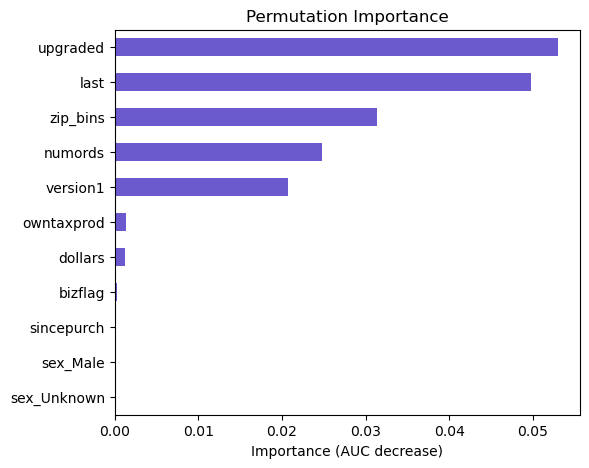

In [11]:
clf1.plot('vimp')

**Conclusion: However, an initial evaluation of clf1 using the Area Under the Curve (AUC)  yielded a score of only 0.709. Although this indicates a degree of predictive capability, there is a clear necessity to refine and enhance the model's performance further. The AUC score serves as a benchmark, highlighting the need for improvements to achieve a more robust and accurate predictive model.**

**Find best AUC performance by using GridSearchCV to find the best hidden layer for this model:**

In [12]:
from sklearn.model_selection import GridSearchCV

hls = [(20,20),(5,3),(4,2),(4,2,2),(5,),(2,2,4,3)]

param_grid = {'hidden_layer_sizes': hls}
scoring = {'AUC': 'roc_auc'}

clf_cv = GridSearchCV(
    clf1.fitted, param_grid, scoring=scoring, cv=5, n_jobs = 4, refit = 'AUC', verbose = 5
)

clf1.data_onehot.mean().round(3)
clf_cv.fit(clf1.data_onehot, clf1.data.res1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                                     max_iter=10000, random_state=1234,
                                     solver='lbfgs'),
             n_jobs=4,
             param_grid={'hidden_layer_sizes': [(20, 20), (5, 3), (4, 2),
                                                (4, 2, 2), (5,),
                                                (2, 2, 4, 3)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [13]:
clf1.data_onehot.head()
pd.DataFrame(clf_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
4,"{'hidden_layer_sizes': (5,)}",0.744572,0.760651,0.764652,0.754180,0.766586,0.758128,0.007998,1
1,"{'hidden_layer_sizes': (5, 3)}",0.742395,0.760488,0.769831,0.750735,0.764770,0.757644,0.009876,2
2,"{'hidden_layer_sizes': (4, 2)}",0.741039,0.760701,0.766126,0.752160,0.765510,0.757107,0.009461,3
3,"{'hidden_layer_sizes': (4, 2, 2)}",0.744941,0.761654,0.768874,0.738818,0.761823,0.755222,0.011367,4
5,"{'hidden_layer_sizes': (2, 2, 4, 3)}",0.735779,0.750410,0.760632,0.748509,0.761959,0.751458,0.009488,5
0,"{'hidden_layer_sizes': (20, 20)}",0.658779,0.665336,0.668929,0.653580,0.653502,0.660025,0.006215,6


**We found that (5,) earn the highest ranking score, with mean_test_AUC = 0.758128**

## 3: Building the second Neural Network Model (clf2):
**- We are trying to improve the clf1 by changing the hidden layer of clf1 to (5,)only.**

**We use:**

- varaibels:  'zip_bins', 'bizflag', 'numords', 'dollars', 'last', 'sincepurch', 'version1', 'owntaxprod', 'upgraded', 'sex'
- hidden layer: (5,)


In [14]:
## (5,) is the best, so we retrain the model with this configuration
clf2 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar,
    hidden_layer_sizes=(5,),
    mod_type="classification",
)
clf2.summary()

Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Model type           : classification
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.764

Raw data             :
 zip_bins  bizflag  numords  dollars  last  sincepurch  version1  owntaxprod  upgraded  sex
       18        0        2    109.5     5          12         0           0         0 Male
        1        0        1     22.0    17           1         0           0         0 Male
        3        0        1     20.0    17          17         0           0         1 Male
       11        1        1     24.5     4          17         1           0      

**Conclusion: We imporved our AUC from 0.709 to 0.764, which is great. And now let's see if the permutation importance will be affected.**

(None, None)

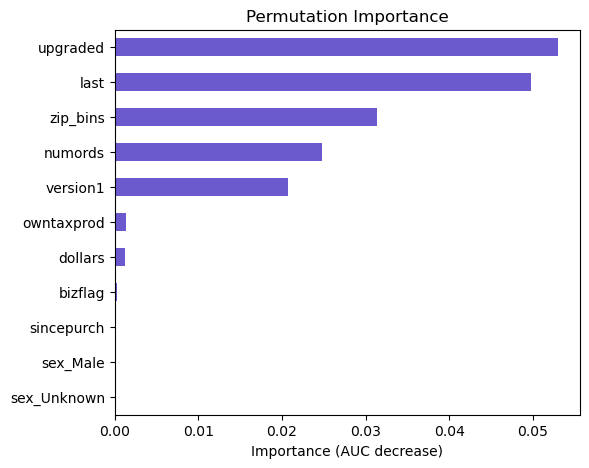

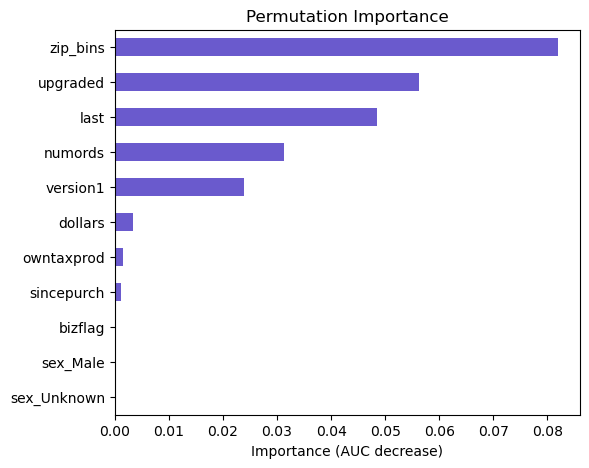

In [15]:
clf1.plot('vimp'), clf2.plot('vimp')

**We noticed that "dollars", "owntaxprod", "sincepurch", "bizflag" and "sex" are always have lower permutation importance, we want to know whether we could improve our model by dropping these low importance variables.**

### Check gains plot and see if model clf1 and clf2 is overfitting:

In [16]:
intuit75k['pred_nn1'] = clf1.predict(intuit75k)['prediction']
intuit75k['pred_nn2'] = clf2.predict(intuit75k)['prediction']

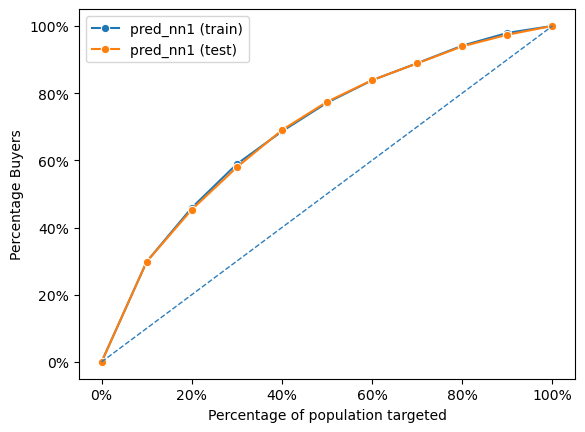

In [17]:
## gain chart of model clf1
dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig1 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn1")

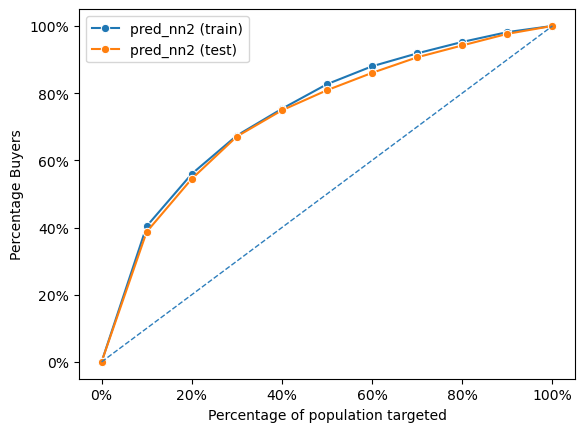

In [18]:
## gain chart of model clf2
fig2 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn2")

**Conclusion: The model seems not overfitting, and we want to know that whether using the high permutation importance features to train the model, will improve our model. Those features are: zip_bins, upgraded, last, numords, and version1.**


## 4: Building the third Neural Network Model (clf3):

**We use:**
- variables: "upgraded", "last", "zip_bins", "numords", "version1"
- hidden layer: (1, ) 


In [19]:
## new model
evar2=[
    "upgraded",
    "last",
    "zip_bins",
    "numords",
    "version1",
]

Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: upgraded, last, zip_bins, numords, version1
Model type           : classification
Hidden_layer_sizes   : (1,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.707

Raw data             :
 upgraded  last  zip_bins  numords  version1
        0     5        18        2         0
        0    17         1        1         0
        1    17         3        1         0
        0     4        11        1         1
        0    10         5        3         0

Estimation data      :
 upgraded      last  zip_bins   numords  version1
        0 -1.137183  1.301549 -0.057079         0
        0  0.119783 -1.646278 -0.863720         0
        1  0.119783 -1.299475 -0.863720         0
   

(None, None)

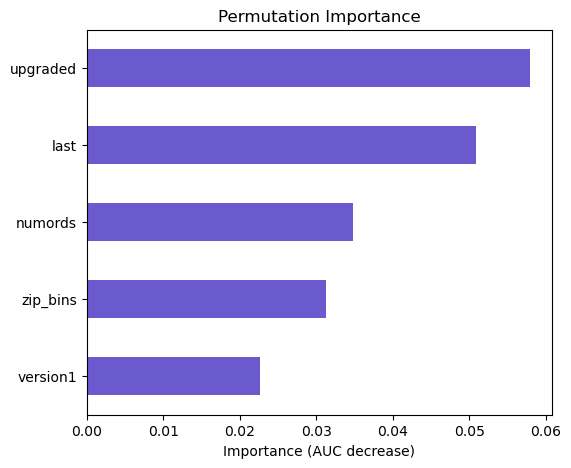

In [20]:
clf3 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar2,
    hidden_layer_sizes=(1,),
    mod_type="classification",
)
clf3.summary(), clf3.plot('vimp')

### Find the best hidden layer for the model:

In [21]:
hls = [(20,20),(5,),(4,2),(4,2,2),(5,2),(2,2,4,3)]

param_grid = {'hidden_layer_sizes': hls}
scoring = {'AUC': 'roc_auc'}

clf_cv = GridSearchCV(
    clf3.fitted, param_grid, scoring=scoring, cv=5, n_jobs = 4, refit = 'AUC', verbose = 5
)

clf3.data_onehot.mean().round(3)
clf_cv.fit(clf3.data_onehot, clf3.data.res1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='tanh', hidden_layer_sizes=(1,),
                                     max_iter=10000, random_state=1234,
                                     solver='lbfgs'),
             n_jobs=4,
             param_grid={'hidden_layer_sizes': [(20, 20), (5,), (4, 2),
                                                (4, 2, 2), (5, 2),
                                                (2, 2, 4, 3)]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [22]:
clf3.data_onehot.head()
pd.DataFrame(clf_cv.cv_results_).iloc[:, 5:].sort_values("rank_test_AUC")

,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC
4,"{'hidden_layer_sizes': (5, 2)}",0.741928,0.764781,0.769494,0.751731,0.767430,0.759073,0.010572,1
1,"{'hidden_layer_sizes': (5,)}",0.741148,0.764175,0.767417,0.753368,0.766325,0.758486,0.010004,2
3,"{'hidden_layer_sizes': (4, 2, 2)}",0.741692,0.762070,0.768169,0.750546,0.764721,0.757440,0.009850,3
2,"{'hidden_layer_sizes': (4, 2)}",0.742031,0.760210,0.767887,0.751513,0.764976,0.757323,0.009446,4
5,"{'hidden_layer_sizes': (2, 2, 4, 3)}",0.731038,0.754684,0.752731,0.710705,0.753321,0.740496,0.017277,5
0,"{'hidden_layer_sizes': (20, 20)}",0.706028,0.707760,0.714076,0.706539,0.705002,0.707881,0.003222,6


In [23]:
clf_cv.best_params_, clf_cv.best_score_.round(3)

({'hidden_layer_sizes': (5, 2)}, 0.759)

## 5: Building the third Neural Network Model (clf4):

**We use:** 

- variables: "upgraded", "last", "zip_bins", "numords", "version1"
- hidden layer: (5,)
    - We found that the gains plot of using (5,) as the hidden layer is better than using (5,2), which is showed below, so we use (5,) as the hidden layer for clf4.

Multi-layer Perceptron (NN)
Data                 : fpb_train
Response variable    : res1
Level                : Yes
Explanatory variables: upgraded, last, zip_bins, numords, version1
Model type           : classification
Hidden_layer_sizes   : (5,)
Activation function  : tanh
Solver               : lbfgs
Alpha                : 0.0001
Batch size           : auto
Learning rate        : 0.001
Maximum itterations  : 10000
random_state         : 1234
AUC                  : 0.76

Raw data             :
 upgraded  last  zip_bins  numords  version1
        0     5        18        2         0
        0    17         1        1         0
        1    17         3        1         0
        0     4        11        1         1
        0    10         5        3         0

Estimation data      :
 upgraded      last  zip_bins   numords  version1
        0 -1.137183  1.301549 -0.057079         0
        0  0.119783 -1.646278 -0.863720         0
        1  0.119783 -1.299475 -0.863720         0
    

(None, None)

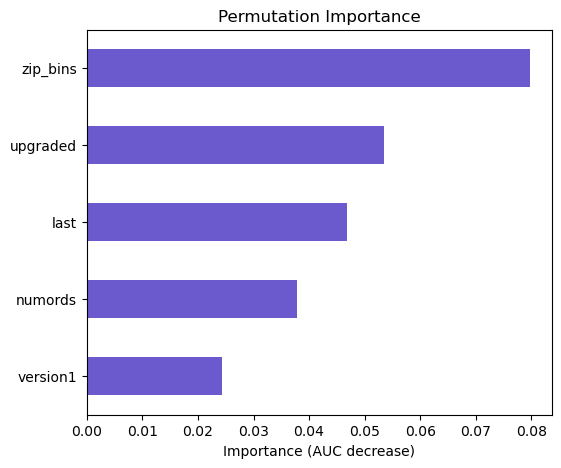

In [24]:
clf4 = rsm.model.mlp(
    data={"fpb_train": intuit75k[intuit75k.training == 1]},
    rvar="res1",
    lev="Yes",
    evar=evar2,
    hidden_layer_sizes=(5,),
    mod_type="classification",
)
clf4.summary(), clf4.plot('vimp')

### Check gains plot and see if our model is overfitting.

In [25]:
intuit75k['pred_nn3'] = clf3.predict(intuit75k)['prediction']
intuit75k['pred_nn4'] = clf4.predict(intuit75k)['prediction']

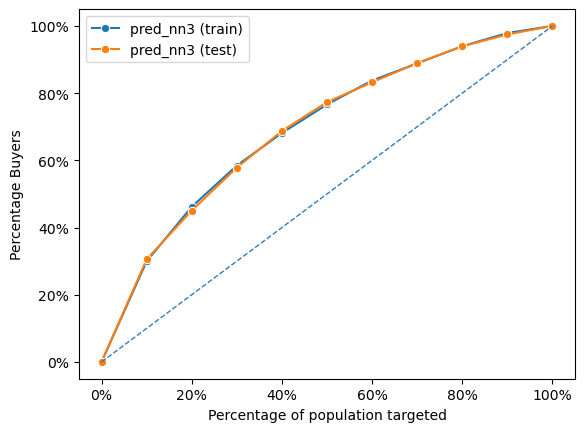

In [26]:
## gain chart of model clf3
dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig3 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn3")

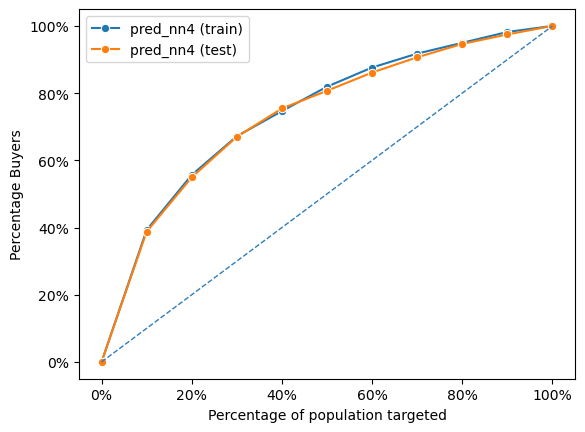

In [27]:
## gain chart of model clf4
fig4 = rsm.gains_plot(dct, "res1", "Yes", "pred_nn4")

**Conclusion: The AUC of model clf3 (0.707) is much lower than the AUC of model clf4 (0.76)**

**After comparing the gains plot, we found that the model is not overfitting, and looks better than fig2 (didn't drop features with (5,)), which means clf4 is perforamce better in comparing traing and testing data (overfitting).**

**However, clf2 has the highest AUC score, which is 0.764, but clf4 only has 0.76. Hence we want to keep these two models for further analysis.**

## Logistic Regression

### 1. By Lasso Selection, we set our logistic model for all possible features first:

Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                 OR     OR%  coefficient  std.error  z.value p.value     
Intercept     0.052  -94.8%        -2.96      0.087  -34.016  < .001  ***
sex[Male]     0.987   -1.3%        -0.01      0.052   -0.249   0.804     
sex[Unknown]  0.991   -0.9%        -0.01      0.074   -0.118   0.906     
zip_bins      0.946   -5.4%        -0.06      0.004  -14.931  < .001  ***
bizflag       1.047    4.7%         0.05      0.048    0.964   0.335     
numords       1.251   25.1%         0.22      0.019   12.010  < .001  ***
dollars       1.001    0.1%         0.00      0.000    3.638  < .001  ***
last          0.958   -4.2%        -0.04      0.002  -17.959  < .001  ***
sincep

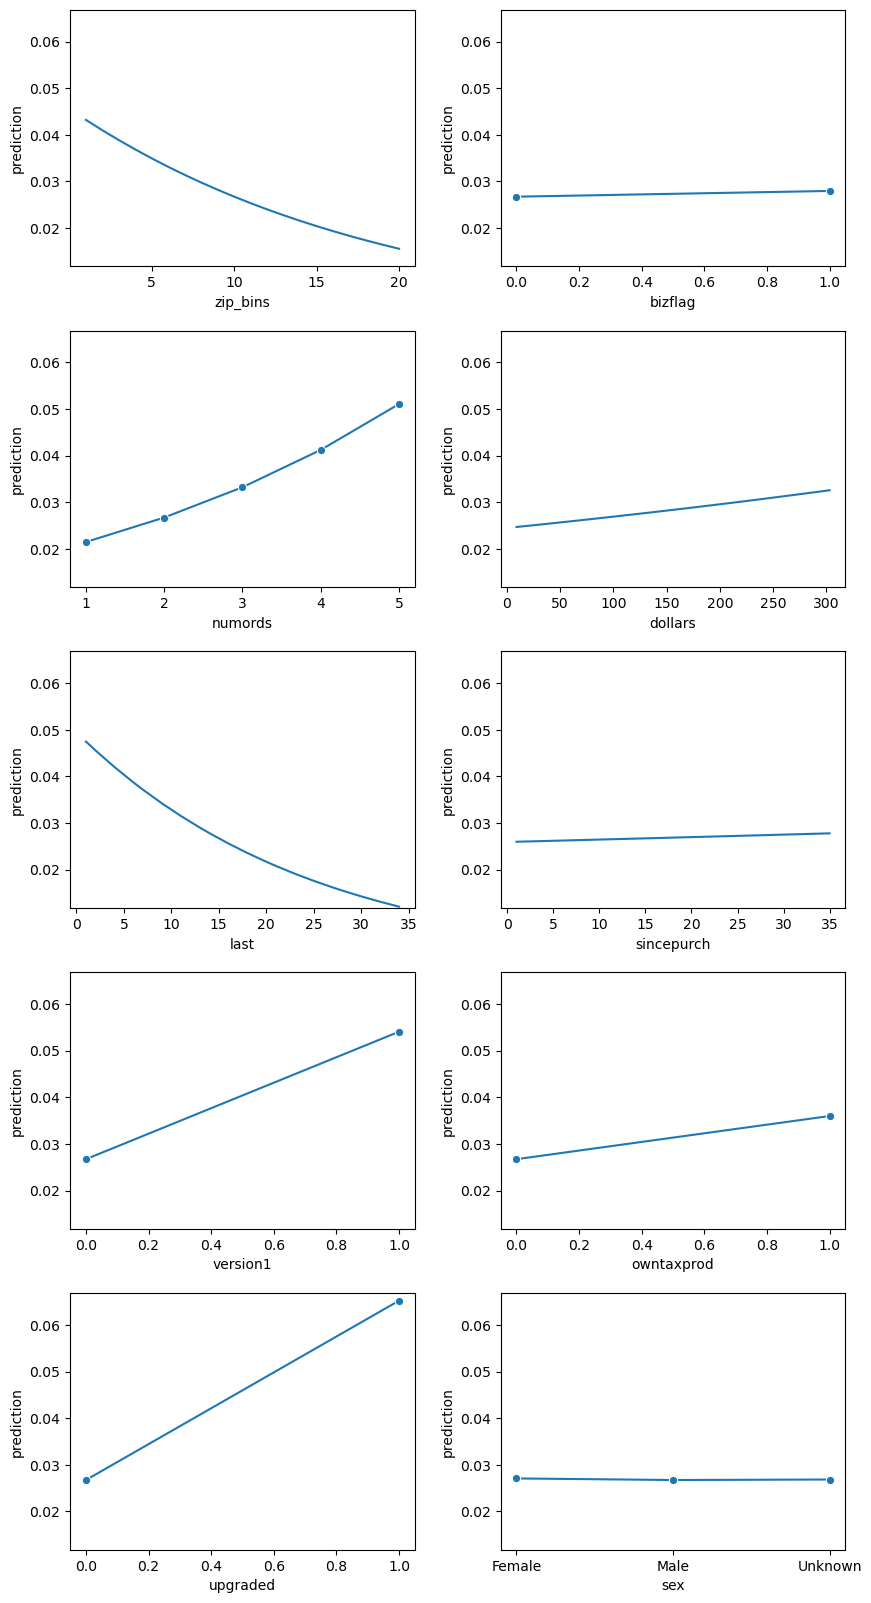

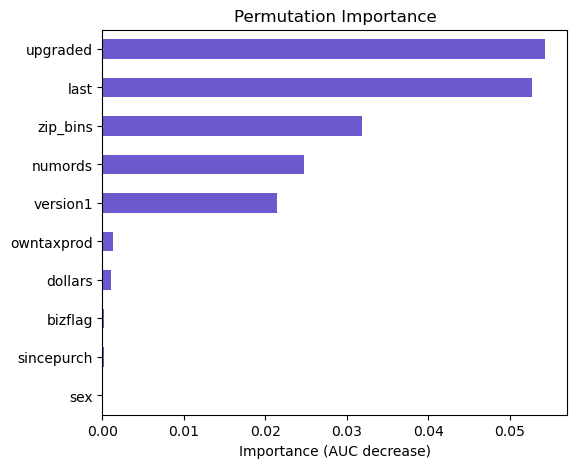

In [28]:
lr1 = rsm.model.logistic(
    data = train_set,
    rvar = 'res1_yes', lev = 1,
    evar = evar
)

lr1.summary(vif = True)

lr1.plot('pred')
lr1.plot('vimp')

### 2. Using standardized data (because neural network can standardized the data automatically, but logistic regression can't.)

Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1_yes
Level                : 1
Explanatory variables: zip_bins, bizflag, numords, dollars, last, sincepurch, version1, owntaxprod, upgraded, sex
Null hyp.: There is no effect of x on res1_yes
Alt. hyp.: There is an effect of x on res1_yes

                 OR     OR%  coefficient  std.error  z.value p.value     
Intercept     0.027  -97.3%        -3.63      0.062  -58.439  < .001  ***
sex[Male]     0.987   -1.3%        -0.01      0.052   -0.249   0.804     
sex[Unknown]  0.991   -0.9%        -0.01      0.074   -0.118   0.906     
zip_bins      0.727  -27.3%        -0.32      0.021  -14.931  < .001  ***
bizflag       1.047    4.7%         0.05      0.048    0.964   0.335     
numords       1.321   32.1%         0.28      0.023   12.010  < .001  ***
dollars       1.082    8.2%         0.08      0.022    3.638  < .001  ***
last          0.666  -33.4%        -0.41      0.023  -17.959  < .001  ***
sincep

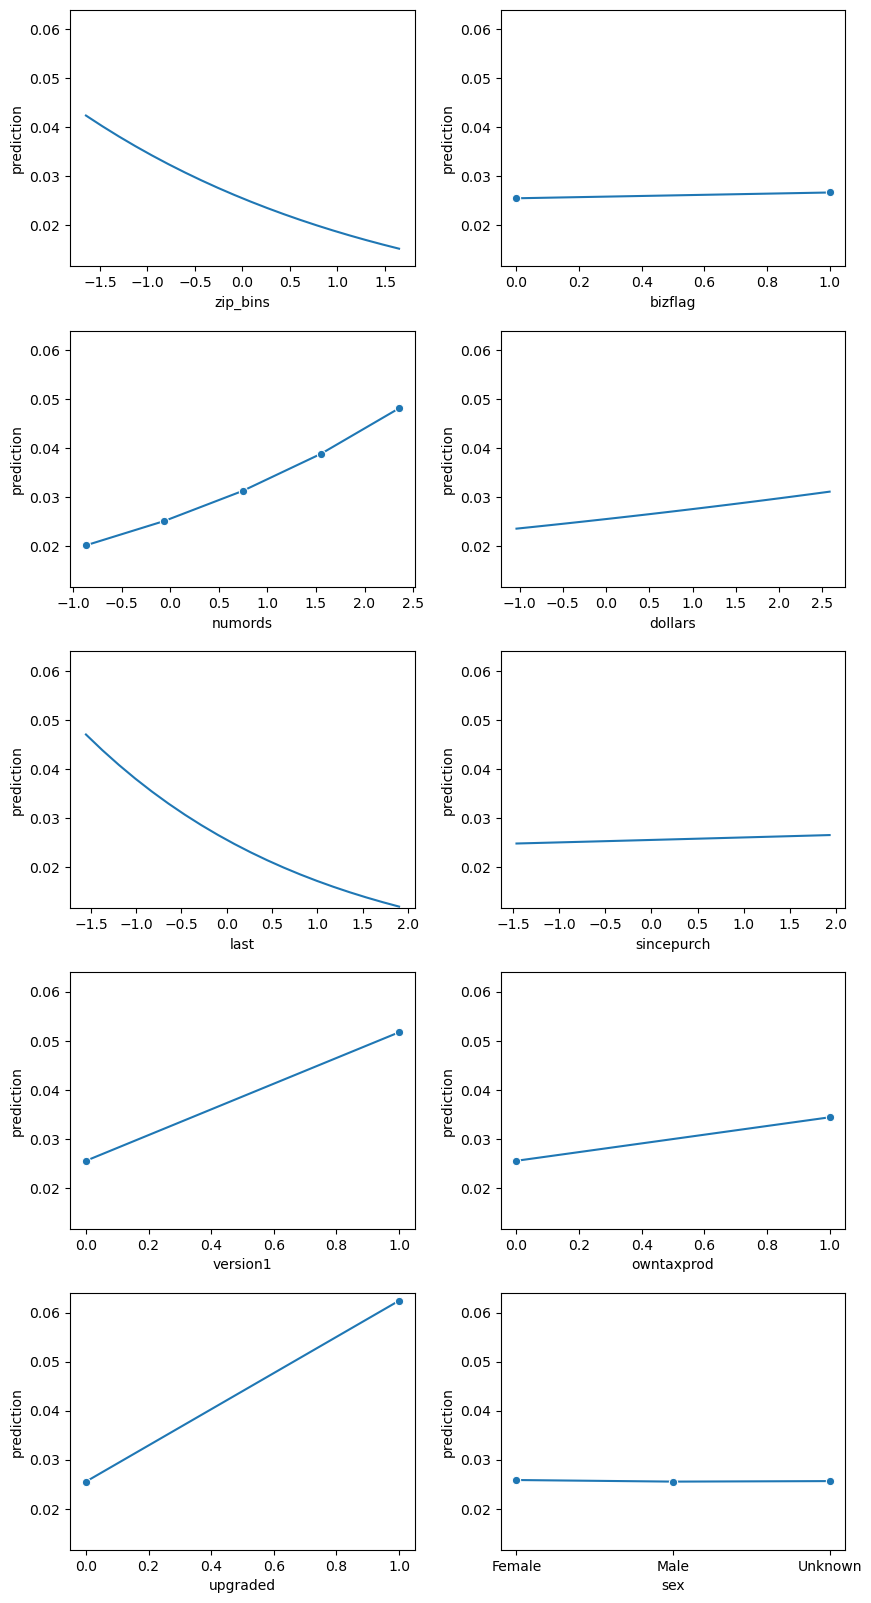

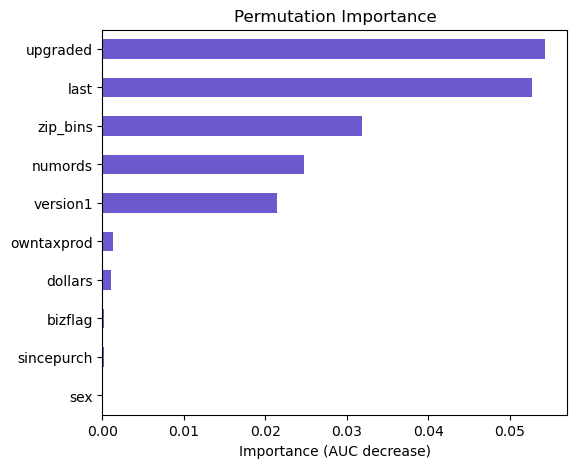

In [29]:
lr1_std = rsm.model.logistic(
    data = data_std_train,
    rvar = 'res1_yes', lev = 1,
    evar = evar
)

lr1_std.summary(vif = True)
lr1_std.plot('pred')
lr1_std.plot('vimp')

**However, we found that there's no significant difference in the model performance when we compare the original data set and the standardized data set. So we decided to use the original data set to train the model.**

### Now let's check the gain plot and see if our logistic 1 model is overfitting.

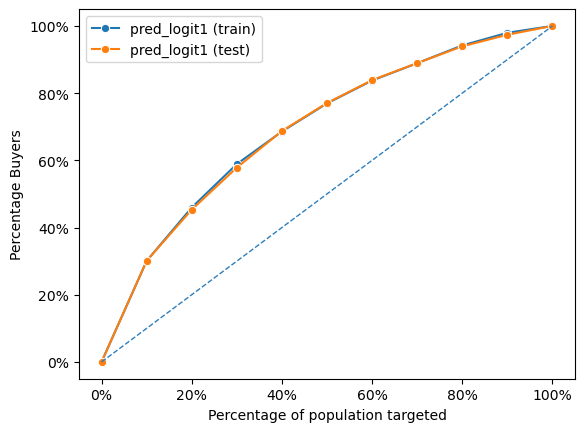

In [30]:
## gains plot
intuit75k['pred_logit1'] = lr1.predict(intuit75k)['prediction']

dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig1 = rsm.gains_plot(dct, "res1", "Yes", "pred_logit1")

**The gains plot is not overfitted, but the model performance (AUC = 0.709) is not good as neural network (AUC_clf2 = 0.764 and AUC_clf4 = 0.76). So we decided to use the permutation importance to select the features and train the model.**

**Based on the permutation importance and the p.val of features, we decided to drop the features that have low permutation importance, not statistically significant (p.val > 0.05) and use the remaining features to train the model.**

**Hence, the remain features are: zip_bins, upgraded, last, numords, and version1.**

## 2. Using the remaining features to build the logistic model(lr_2):

In [31]:
evar3 = ['zip_bins','upgraded','last','numords','version1']

Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, upgraded, last, numords, version1
Null hyp.: There is no effect of x on res1
Alt. hyp.: There is an effect of x on res1

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.054  -94.6%        -2.93      0.069  -42.412  < .001  ***
zip_bins   0.946   -5.4%        -0.06      0.004  -14.892  < .001  ***
upgraded   2.662  166.2%         0.98      0.049   19.811  < .001  ***
last       0.958   -4.2%        -0.04      0.002  -17.999  < .001  ***
numords    1.306   30.6%         0.27      0.015   17.605  < .001  ***
version1   2.132  113.2%         0.76      0.051   14.710  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.07
Pseudo R-squared (McFadden adjusted): 0.069
Area under the RO Curve (AUC): 0.707
Log-likelihood: -9343.617, AIC: 18699.233, BIC: 1875

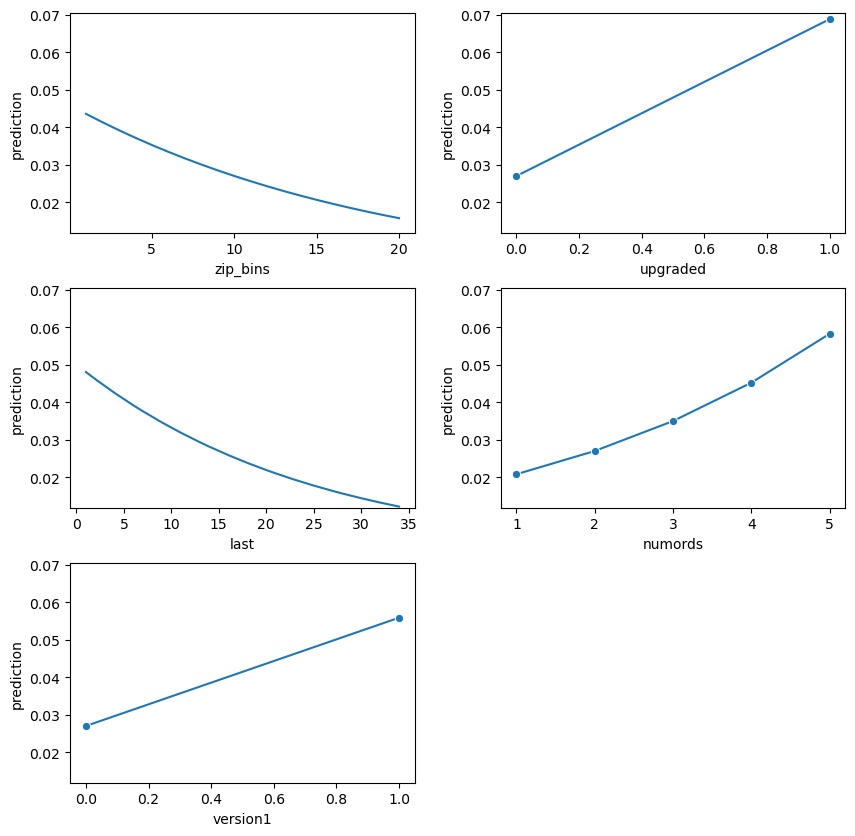

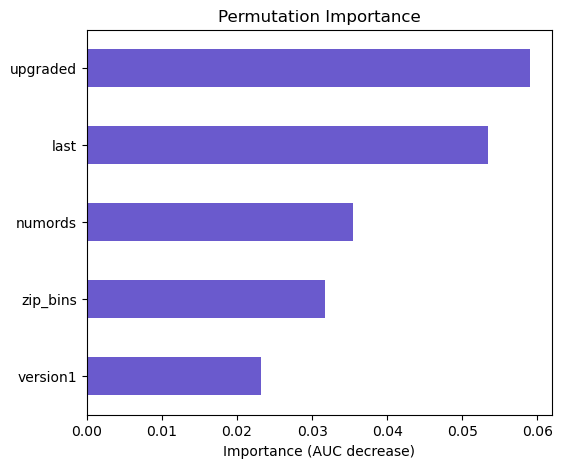

In [32]:
## using new evar3 to train the model
lr_2 = rsm.model.logistic(
    data = train_set,
    rvar = 'res1',
    lev = 'Yes',
    evar = evar3,
)

lr_2.summary(vif = True)

lr_2.plot('pred')
lr_2.plot('vimp')

**We got AUC = 0.707 from lr2, which is lower than the AUC from lr1.**

### Now let's check the gain plot for our new model and see if it is overfitting.

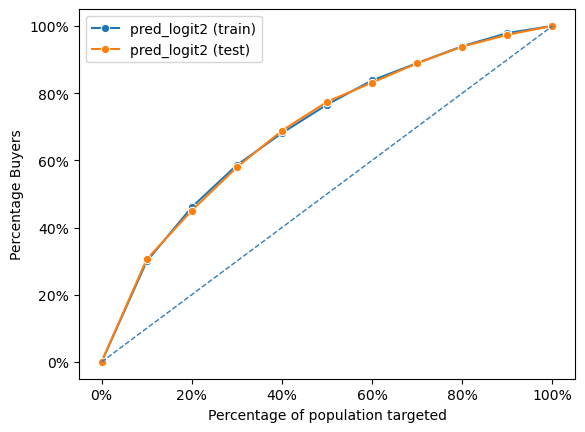

In [33]:
## gains plot
intuit75k['pred_logit2'] = lr_2.predict(intuit75k)['prediction']

dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig2 = rsm.gains_plot(dct, "res1", "Yes", "pred_logit2")

## 3. The gain plot is not overfitted, but still, the model performance is not good as neural network. So we decided to add interaction terms by our common knowledge to the model and see if the model performance will be affected.

Logistic regression (GLM)
Data                 : Not provided
Response variable    : res1
Level                : Yes
Explanatory variables: zip_bins, upgraded, last, numords, version1
Null hyp.: There is no effect of x on res1
Alt. hyp.: There is an effect of x on res1

                     OR     OR%  coefficient  std.error  z.value p.value     
Intercept         0.079  -92.1%        -2.53      0.093  -27.262  < .001  ***
zip_bins          0.930   -7.0%        -0.07      0.008   -9.495  < .001  ***
upgraded          2.646  164.6%         0.97      0.049   19.747  < .001  ***
last              0.958   -4.2%        -0.04      0.002  -18.065  < .001  ***
numords           1.118   11.8%         0.11      0.030    3.711  < .001  ***
version1          0.919   -8.1%        -0.08      0.105   -0.807    0.42     
zip_bins:numords  1.007    0.7%         0.01      0.003    2.623   0.009   **
version1:numords  1.376   37.6%         0.32      0.033    9.552  < .001  ***

Signif. codes:  0 '***' 0.

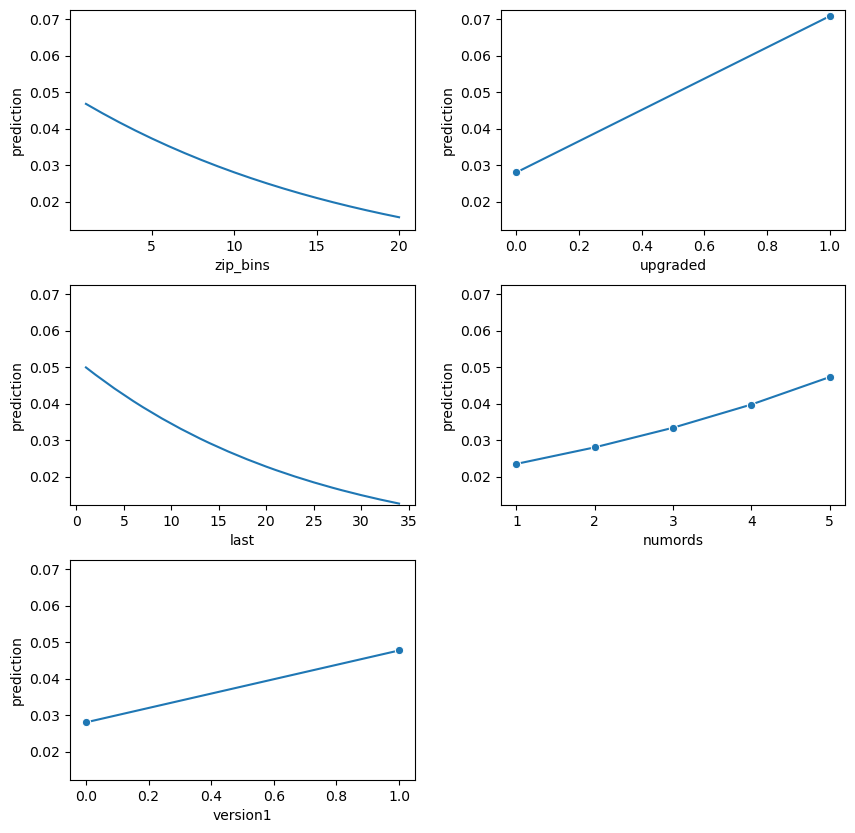

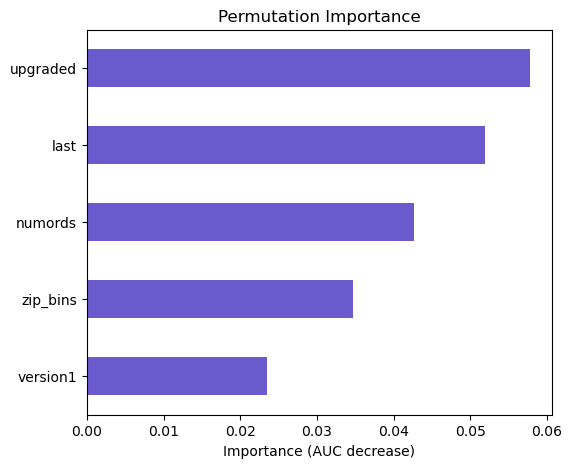

In [34]:
lr_hand = rsm.model.logistic(
    data = train_set,
    rvar = 'res1',
    lev = 'Yes',
    evar = evar3,
    ivar = [
            'zip_bins:numords',
            ## we want to interaction terms "zip_bins:numords" because we think that people in different zip_bins have different income levels, and they may have different purchasing power.
            'version1:numords',
            ## we want to interaction terms "version1:numords" because we think that people who have used version1 may have different purchasing power.
    ]
)


lr_hand.summary(vif = True)

lr_hand.plot('pred')
lr_hand.plot('vimp')

**We got AUC = 0.711 from lr3, which is much better than the AUC from lr2.**

### Now let's check the gain plot for our new model and see if it is overfitting.

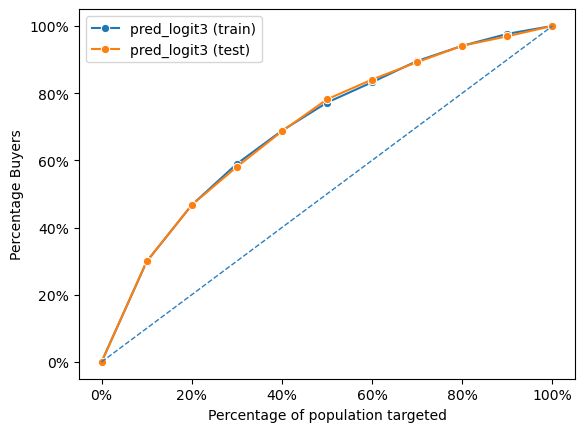

In [35]:
## gains plot
intuit75k['pred_logit3'] = lr_hand.predict(intuit75k)['prediction']

dct = {"train": intuit75k[intuit75k['training'] == 1], "test": intuit75k[intuit75k['training'] == 0]}
fig3 = rsm.gains_plot(dct, "res1", "Yes", "pred_logit3")

**The gain plot is not overfitted, and we got our best logistic model lr3 with AUC = 0.711.**

## Predict:

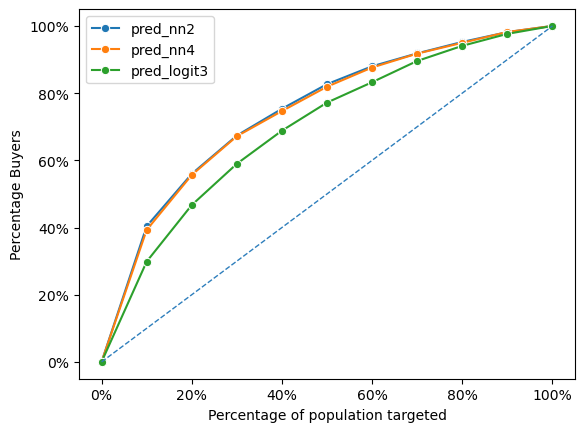

In [36]:
fig = rsm.gains_plot(intuit75k[intuit75k['training'] == 1], "res1", "Yes", ["pred_nn2", "pred_nn4", "pred_logit3"])

## Gains plot for the best neural network model and the best logistic regression model:

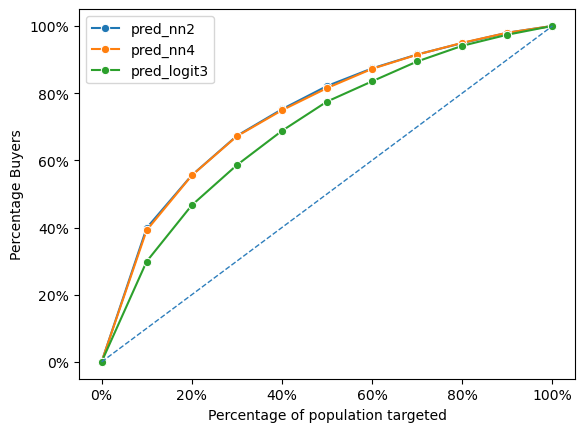

In [37]:
fig = rsm.gains_plot(intuit75k, "res1", "Yes", ["pred_nn2","pred_nn4", "pred_logit3"])

**After we compare the gains plot of the best neural network model and the best logistic regression model, we found that the pred_nn4 curve is above pred_logit3 curve, which means the best neural network model has better performance than the best logistic regression model.**

**Hence, we decided to use the best neural network model to predict the upgrade of the customers, and calculate the profit.**

## Profit calucation

In [38]:
mail_cost = 1.41
margin = 60 
total_business = 801821 - 38487

In here we calculate the break-even point using the mail cost the margin.

In [39]:
break_even = mail_cost / margin
break_even

0.0235

Mark the target users for each model using break-even as the threshold.

In [40]:
intuit75k['target_logit'] = intuit75k['pred_logit3'] > break_even
intuit75k['target_nn2'] = intuit75k['pred_nn2'] > break_even
intuit75k['target_nn4'] = intuit75k['pred_nn4'] > break_even

In [41]:
intuit75k_test = intuit75k[intuit75k.training == 0]

## Test set profit


Calculate the profit from test set using different models to see which model is the best.

__logistic regression__:

In [42]:
target_logit = intuit75k_test['target_logit'].sum() # number of target users in test set using the logit model
response_logit_set = intuit75k_test[(intuit75k_test.target_logit == True)&(intuit75k_test.res1_yes == 1)]# data set of target users who responded in test set
response_logit = response_logit_set.shape[0] #number of target users who responded
response_rate_logit = (response_logit / target_logit) * 0.5 # response rate of target users which is half of the actual first wave response rate
cost_logit = target_logit * mail_cost # cost of mailing 
margin_logit = response_rate_logit * target_logit * margin # margin from the target users
profit_logit_test = margin_logit - cost_logit # profit from the target users 
print(f'target_logit : {target_logit}\n'
    f'response_logit : {response_logit}\n'
    f'response_rate_logit : {response_rate_logit}\n'
    f'cost_logit : {cost_logit}\n'
    f'margin_logit : {margin_logit}\n'
    f'profit_logit : {profit_logit_test}\n')

target_logit : 15924
response_logit : 987
response_rate_logit : 0.03099095704596835
cost_logit : 22452.84
margin_logit : 29610.0
profit_logit : 7157.16



__Neural network 2: clf2__

In [43]:
target_neural = intuit75k_test['target_nn2'].sum() # number of target users in test set using the nn2 model
response_neural_set = intuit75k_test[(intuit75k_test.target_nn2 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
cost_neural = target_neural * mail_cost # cost of mailing 
margin_neural = response_rate_neural * target_neural * margin # margin from the target users 
profit_neural_test_2 = margin_neural - cost_neural # profit from the target users
print(f'target_neural : {target_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_test_2}\n')

target_neural : 13269
response_neural : 942
response_rate_neural : 0.035496269500339135
cost_neural : 18709.289999999997
margin_neural : 28260.0
profit_neural : 9550.710000000003



__Neural network 4: clf4__

In [44]:
target_neural = intuit75k_test['target_nn4'].sum() # number of target users in test set using the nn4 model
response_neural_set = intuit75k_test[(intuit75k_test.target_nn4 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
cost_neural = target_neural * mail_cost # cost of mailing 
margin_neural = response_rate_neural * target_neural * margin # margin from the target users 
profit_neural_test_4 = margin_neural - cost_neural # profit from the target users
print(f'target_neural : {target_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_test_4}\n')

target_neural : 13413
response_neural : 949
response_rate_neural : 0.035376127637366736
cost_neural : 18912.329999999998
margin_neural : 28470.000000000004
profit_neural : 9557.670000000006



## Full scale profit comparsion

Calculate the profit from full set using different models to see which model is the best.(Full set is the business that did not response on the first wave mail)

__logistic regression__:

In [45]:
target_logit = intuit75k_test['target_logit'].sum() # number of target users using the logit model
target_rate_logit = target_logit / intuit75k_test.shape[0] # rate of target users in test data
response_logit_set = intuit75k_test[(intuit75k_test.target_logit == True)&(intuit75k_test.res1_yes == 1)]# data set of target users who responded in test set
response_logit = response_logit_set.shape[0] #number of target users who responded
response_rate_logit = (response_logit / target_logit) * 0.5 # response rate of target users which is half of the actual first wave response rate
n_logit = total_business * target_rate_logit # scaled up number of target users in the total business
cost_logit = n_logit * mail_cost # cost of mailing to the target users in the full business scale
margin_logit = response_rate_logit * n_logit * margin # margin from the target users in the full business scale
profit_logit = margin_logit - cost_logit # profit from the target users in the full business scale
print(f'target_logit : {target_logit}\n'
    f'target_rate_logit : {target_rate_logit}\n'
    f'response_logit : {response_logit}\n'
    f'response_rate_logit : {response_rate_logit}\n'
    f'n_logit : {n_logit}\n'
    f'cost_logit : {cost_logit}\n'
    f'margin_logit : {margin_logit}\n'
    f'profit_logit : {profit_logit}\n')

target_logit : 15924
target_rate_logit : 0.7077333333333333
response_logit : 987
response_rate_logit : 0.03099095704596835
n_logit : 540236.9162666666
cost_logit : 761734.0519359999
margin_logit : 1004547.544
profit_logit : 242813.4920640001



__Neural network 2: clf2__

In [46]:
target_neural = intuit75k_test['target_nn2'].sum() # number of target users using the nn2 model
target_rate_neural = target_neural / intuit75k_test.shape[0] # rate of target users in test data
response_neural_set = intuit75k_test[(intuit75k_test.target_nn2 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
n_neural = total_business * target_rate_neural # scaled up number of target users in the total business
cost_neural = n_neural * mail_cost # cost of mailing to the target users in the full business scale
margin_neural = response_rate_neural * n_neural * margin # margin from the target users in the full business scale
profit_neural_2 = margin_neural - cost_neural # profit from the target users in the full business scale
print(f'target_neural : {target_neural}\n'
    f'target_rate_neural : {target_rate_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'n_neural : {n_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_test_2}\n')

target_neural : 13269
target_rate_neural : 0.5897333333333333
response_neural : 942
response_rate_neural : 0.035496269500339135
n_neural : 450163.50426666666
cost_neural : 634730.541016
margin_neural : 958747.504
profit_neural : 9550.710000000003



__Neural network 4: clf4__

In [47]:
target_neural = intuit75k_test['target_nn4'].sum() # number of target users using the nn4 model
target_rate_neural = target_neural / intuit75k_test.shape[0] # rate of target users in test data
response_neural_set = intuit75k_test[(intuit75k_test.target_nn4 == True)&(intuit75k_test.res1_yes == 1)] # data set of target users who responded in test set
response_neural = response_neural_set.shape[0] #number of target users who responded
response_rate_neural = (response_neural / target_neural) * 0.5 # response rate of target users which is half of the actual first wave response rate
n_neural = total_business * target_rate_neural # scaled up number of target users in the total business
cost_neural = n_neural * mail_cost # cost of mailing to the target users in the full business scale
margin_neural = response_rate_neural * n_neural * margin # margin from the target users in the full business scale
profit_neural_4 = margin_neural - cost_neural # profit from the target users in the full business scale
print(f'target_neural : {target_neural}\n'
    f'target_rate_neural : {target_rate_neural}\n'
    f'response_neural : {response_neural}\n'
    f'response_rate_neural : {response_rate_neural}\n'
    f'n_neural : {n_neural}\n'
    f'cost_neural : {cost_neural}\n'
    f'margin_neural : {margin_neural}\n'
    f'profit_neural : {profit_neural_4}\n')

target_neural : 13413
target_rate_neural : 0.5961333333333333
response_neural : 949
response_rate_neural : 0.035376127637366736
n_neural : 455048.8418666666
cost_neural : 641618.8670319999
margin_neural : 965871.9546666666
profit_neural : 324253.0876346667



In [48]:
mod_perf = pd.DataFrame(
    {
        "model": [
            "logit",
            "neural network clf2",
            "neural network clf4"
        ],
        "profit_test":[profit_logit_test, profit_neural_test_2, profit_neural_test_4 ],
        "profit_fullset": [profit_logit, profit_neural_2, profit_neural_4],
    }
)
mod_perf

,model,profit_test,profit_fullset
0,logit,7157.16,242813.492064
1,neural network clf2,9550.71,324016.962984
2,neural network clf4,9557.67,324253.087635


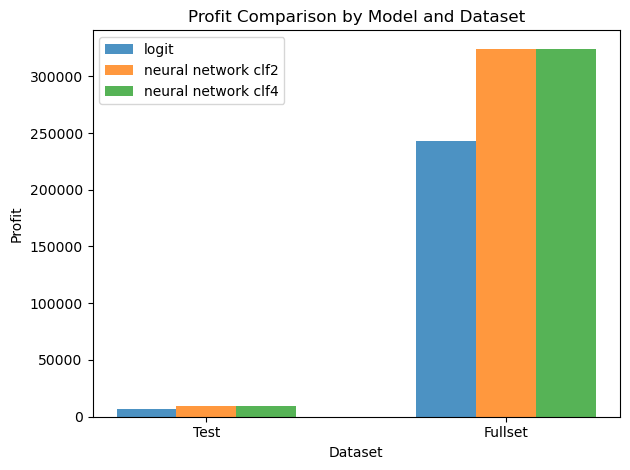

In [49]:
# Number of model groups and datasets
n_models = len(mod_perf['model'])
n_datasets = 2  # 'Test' and 'Fullset'

# Set the bar width
bar_width = 0.2

# Set the opacity
opacity = 0.8

# Set the position of the bars on the x-axis
index = np.arange(n_datasets)

# Create the plot
fig, ax = plt.subplots()

# Plotting the bars for each model
for i, model in enumerate(mod_perf['model']):
    rects = ax.bar(index + i * bar_width, 
                   mod_perf.loc[mod_perf['model'] == model, ['profit_test', 'profit_fullset']].values.flatten(), 
                   bar_width, alpha=opacity, label=model)

# Adding labels and title
ax.set_xlabel('Dataset')
ax.set_ylabel('Profit')
ax.set_title('Profit Comparison by Model and Dataset')
ax.set_xticks(index + bar_width / 2 * (n_models - 1))
ax.set_xticklabels(['Test', 'Fullset'])
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

As we can see here, the best model is clf4, which has the highest profit in both full set and test set. Thus we decided to use clf4 as our final model to do the prediction.

## Final list for prediction

In the Final prediction in the test set, we filter out the users who already responded to the first wave mail, and we multiple the predict probability of response by 0.5 because the second wave mail response probability is half of the first wave mail. And we do a new prediction based on the best model and these 2 additional conditions. 

In [50]:
intuit75k['target_nn'] = ((intuit75k['pred_nn4']*0.5) > break_even)&(intuit75k['res1_yes'] == 0)
intuit75k_test = intuit75k[intuit75k.training == 0]

In [51]:
number = intuit75k_test['target_nn'].sum()
print(number)

6166


In [52]:
columns = ['id', 'target_nn']
list_id = intuit75k_test[columns]
new_list_id = list_id.rename(columns={'target_nn':'mailto_wave2'})
new_list_id.to_csv('Group20.csv', index = False)

## Chatgpt

While working on this assignment, we did indeed utilize Generative AI tools such as ChatGPT to assist in our work. We primarily used ChatGPT for the following aspects:

Explaining Course Content: We asked ChatGPT to help us explain the content from our teacher's class slides. This was immensely beneficial in understanding the background and concepts required to complete the assignment since the content from the teacher's lectures served as the foundational knowledge needed for the assignment.

Debugging and Understanding Code: Occasionally, we encountered difficulties or errors while coding. We leveraged discussions with ChatGPT to diagnose issues and obtain potential solutions. While ChatGPT cannot directly write code, through discussions, it helped us comprehend the logic errors in the code. Although it cannot write code for us, it enabled us to better understand the essence of the issues and solve them ourselves.

Overall, Generative AI tools played a pivotal role in assisting us with grasping course content and addressing technical issues. However, it is important to emphasize that Generative AI tools cannot replace our thinking and understanding. They serve as auxiliary tools to help us work more efficiently, but the ultimate thinking and judgment come from our own minds.

Throughout the entire assignment process, we found Generative AI tools to be highly useful, but they do have some limitations. For instance, at times, ChatGPT may provide explanations that are not detailed enough or are inaccurate, necessitating further research on our part. Additionally, Generative AI tools may not fully comprehend the context of our questions, so we sometimes need to express our queries more clearly.
